# Week 6 – Challenges

## Accident database enrichment

The database of accidents has been downloaded from a government website. It does not have any adresses geolocalized. Your goal in this challenge is get use to update yoru odata with an API. We will use Baidu API to query the adresses and obtain a location. 

### API call 

🤔 follow the steps from the course to get your own API key and try to get query baidu to get an an adress geolocalized. Store the result in longitude and latitude variables

In [8]:
# some import might be useful
import requests
from coords import gcj02_decrypt

In [9]:
adress = '上海市宝山区上大路99号'
xnode='宝山区上大路99号'
def call_baidu(xnode):
    baidu_api_url = 'https://api.map.baidu.com'
    baidu_api_endpoint = '/geocoding/v3/'
    with open('baidu_ak',encoding='utf-8') as fp:
        baidu_application_key = fp.read().strip()
    address_in_china = {'city':'上海市','address':xnode}
    params = {
        'city': address_in_china['city'],
        'address': address_in_china['address'],
        'output':'json',
        'ret_coordtype':'gcj02ll',
        'ak': baidu_application_key
        }
    query_parameters = '&'.join([f'{k}={v}' for k,v in params.items()]) 
    query = f'{baidu_api_url}{baidu_api_endpoint}?{query_parameters}'
    r = requests.get(query)
    data = r.json()
    longitude=data['result']['location']['lng']
    latitude=data['result']['location']['lat']
    new_latitude,new_longitude = gcj02_decrypt(latitude, longitude)
    return(new_longitude,new_latitude)

🤔 now that the address is geolocalized we still need to unshift the coordinate. Right now the coordinate are in GCJ02 and we need them in WG84. Use the code from the course to unshift it. 

In [9]:
lon,lat=call_baidu(xnode)
print(lon,lat)

121.38315633823919 31.317652943000628



### Use pandas to Query the database of addresses

Now that you are capable of getting one query right, let's try to query baidu for 100 accidents that happened on a street of your choice. 

the table is called __`roadtraffic`__ and the field are as follows:
- `ìd`	INTEGER	NULL	
- `address`	TEXT(255,0)	NULL	
- `date`	TEXT(255,0)	NULL	
- `cause`	TEXT(255,0)	NULL	
- `longitude`	real	Null	
- `latitude`	real	Null	
- `done`	TEXT	0	

🤔 step 1 create a pandas dataframe with a query in accidents.sqlite on the table `roadtraffic` selecting only the rows where `done` is not 1 and display the first 5 lines

In [1]:
# some import might be useful
import pandas as pd
import geopandas as gpd
import sqlite3

sql_cmd = 'SELECT * FROM roadtraffic'

conn=sqlite3.connect('./accidents.sqlite')

accident=pd.read_sql(sql=sql_cmd,con=conn)

In [2]:
accident

,id,address,date,cause,longitude,latitude,done
0,3101010200700018,西藏南路、方浜西路,2007-06-25 12:32:00.0,上海市公安局黄浦分局交通警察支队事故违章审理科,NaN,NaN,0
1,3101010200700068,南京西路、新昌路,2007-06-15 21:00:00.0,上海市公安局黄浦分局交通警察支队机动责任区,NaN,NaN,0
2,3101010200700079,复兴东路、四牌楼路,2007-06-15 05:30:00.0,上海市公安局黄浦分局交通警察支队事故违章审理科,NaN,NaN,0
3,3101010200700081,南仓街82弄,2007-01-21 11:00:00.0,上海市公安局黄浦分局交通警察支队事故违章审理科,NaN,NaN,0
4,3101010200700100,四川中路、香港路,2007-06-23 08:45:00.0,上海市公安局黄浦分局交通警察支队事故违章审理科,NaN,NaN,0
...,...,...,...,...,...,...,...
935892,3101099201607848,水电路进汶水东路南约100米,2016-11-17 07:00:00.0,上海市公安局虹口分局交通警察支队四大队,NaN,NaN,0
935893,3101099201607805,同心路出中山北一路东约100米,2016-11-16 08:06:00.0,上海市公安局虹口分局交通警察支队三大队,NaN,NaN,0
935894,3101099201607869,安汾路出江杨南路东约200米,2016-11-17 16:10:00.0,上海市公安局虹口分局交通警察支队事故违章审理科,NaN,NaN,0
935895,3101099201607811,四平路进吴淞路南约00米,2016-06-16 11:00:00.0,南空分中心,NaN,NaN,0


In [3]:
Nanjing_df=accident[accident.address.str.contains('南京西路')].sample(100)

🤔 step 2 select the rows where your street address name is in the address field as a new dataframe

In [4]:
import re

In [5]:
while len(Nanjing_df[Nanjing_df.done != 1]) > 0:
    row=Nanjing_df[Nanjing_df.done !=1].sample(1)
    print(row.index)
    address=str(row.address)
    address=re.sub('(([东北南西]约)?\d+米)','',address)
    print(row.address,address)
    break

Int64Index([432921], dtype='int64')
432921    南京西路出铜仁路西约5米
Name: address, dtype: object 432921    南京西路出铜仁路
Name: address, dtype: object


🤔 step 3 for each of these rows, query baidu to location AND unshift it to WGS84. Save the result in the new dataframe you just created

In [10]:
while len(Nanjing_df[Nanjing_df.done != 1]) > 0:
    row=Nanjing_df[Nanjing_df.done !=1].sample(1)
    address=str(row.address)
    longitude,latitude=call_baidu(address)
    #lat,lon=gcj02_decrypt(latitude,longitude)
    Nanjing_df.at[row.index,'done']=1
    Nanjing_df.at[row.index,'longitude']=longitude
    Nanjing_df.at[row.index,'latitude']=latitude
Nanjing_df

,id,address,date,cause,longitude,latitude,done
8645,3101010201300919,南京西路黄陂北路西约50米,2013-01-20 19:50:00.0,上海市公安局黄浦分局交通警察支队隧桥责任区,121.441444,31.225638,1
395589,3101062201600530,南京西路1618号—久光百货,2016-01-30 16:34:00.0,上海市公安局静安分局交通警察支队事故审理大队,121.441597,31.225822,1
433096,3101068201601567,南京西路进石门一路西约50米,2016-03-29 19:10:00.0,上海市公安局静安分局交通警察支队二中队,121.441444,31.225638,1
395473,3101062201509261,延安西路南京西路西约15米,2015-12-15 09:20:00.0,众国分中心,121.441444,31.225638,1
399014,3101063201300184,南京西路江宁路(南)北约5米,2013-01-14 22:20:00.0,上海市公安局静安分局交通警察支队事故审理大队,121.455562,31.227879,1
...,...,...,...,...,...,...,...
380789,3101060201306469,华山路进南京西路北约5米,2013-10-18 15:24:00.0,上海市公安局静安分局交通警察支队一中队,121.452046,31.230159,1
417003,3101066201201628,南京西路进华山路西约30米,2012-04-24 18:30:00.0,上海市公安局静安分局交通警察支队事故审理大队,121.441444,31.225638,1
382030,3101060201501096,南京西路818号--长春藤运通大厦,2015-02-13 18:50:00.0,上海市公安局静安分局交通警察支队事故审理大队,121.456408,31.233118,1
109731,3101016201308705,南京西路成都北路北约0米,2013-05-28 22:40:00.0,上海市公安局黄浦分局交通警察支队隧桥责任区,121.461914,31.234832,1


### create a geopandas dataframe 

🤔 step 4 create a geopandas dataframe from the pandas dataframe. initialize the geometry column using the geopandas function [points_from_xy](https://geopandas.org/docs/reference/api/geopandas.points_from_xy.html?highlight=points_from#geopandas.points_from_xy) and initialize the crs (the projection) to 4326 (you can check it on [epsg.io/4326](https://epsg.io/4326))

In [11]:
gdf=gpd.GeoDataFrame(Nanjing_df,geometry=gpd.points_from_xy(Nanjing_df['longitude'],Nanjing_df['latitude']),crs=4326)
gdf

,id,address,date,cause,longitude,latitude,done,geometry
8645,3101010201300919,南京西路黄陂北路西约50米,2013-01-20 19:50:00.0,上海市公安局黄浦分局交通警察支队隧桥责任区,121.441444,31.225638,1,POINT (121.44144 31.22564)
395589,3101062201600530,南京西路1618号—久光百货,2016-01-30 16:34:00.0,上海市公安局静安分局交通警察支队事故审理大队,121.441597,31.225822,1,POINT (121.44160 31.22582)
433096,3101068201601567,南京西路进石门一路西约50米,2016-03-29 19:10:00.0,上海市公安局静安分局交通警察支队二中队,121.441444,31.225638,1,POINT (121.44144 31.22564)
395473,3101062201509261,延安西路南京西路西约15米,2015-12-15 09:20:00.0,众国分中心,121.441444,31.225638,1,POINT (121.44144 31.22564)
399014,3101063201300184,南京西路江宁路(南)北约5米,2013-01-14 22:20:00.0,上海市公安局静安分局交通警察支队事故审理大队,121.455562,31.227879,1,POINT (121.45556 31.22788)
...,...,...,...,...,...,...,...,...
380789,3101060201306469,华山路进南京西路北约5米,2013-10-18 15:24:00.0,上海市公安局静安分局交通警察支队一中队,121.452046,31.230159,1,POINT (121.45205 31.23016)
417003,3101066201201628,南京西路进华山路西约30米,2012-04-24 18:30:00.0,上海市公安局静安分局交通警察支队事故审理大队,121.441444,31.225638,1,POINT (121.44144 31.22564)
382030,3101060201501096,南京西路818号--长春藤运通大厦,2015-02-13 18:50:00.0,上海市公安局静安分局交通警察支队事故审理大队,121.456408,31.233118,1,POINT (121.45641 31.23312)
109731,3101016201308705,南京西路成都北路北约0米,2013-05-28 22:40:00.0,上海市公安局黄浦分局交通警察支队隧桥责任区,121.461914,31.234832,1,POINT (121.46191 31.23483)


🤔 step 5 plot the points using the plot function 

<AxesSubplot:>

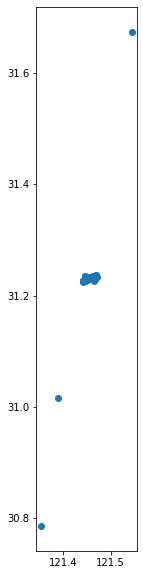

In [15]:
gdf.plot(figsize=(15,10))

🤔 step 6 optionnal, plot using a shanghai basemap like in the course

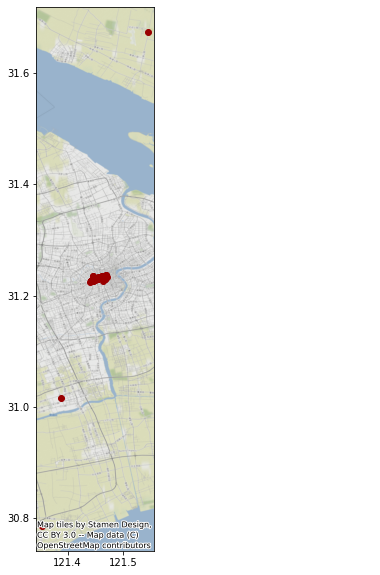

In [16]:
import contextily as cx
ax = gdf.plot(figsize = (15,10),color = '#990000')
cx.add_basemap(ax,crs = gdf.crs.to_string())

## mobike speed experiment

To provide a new option on a housing website, a real estate company contact you and ask you how far from a subway station is a 10min bike ride. To answer this question you need to know the speed at wich people bike in Shanghai in average. Fortunately you have a large dataset with bike travel that could provide this exact information. So you are gonna get the average biking speed of a mobike user in Shanghai. 

🤔 step 1 load the mobike dataframe into a normal pandas dataframe

In [2]:
import pandas as pd
mobike_df=pd.read_csv("UTSEUS-MOBIKE-shanghai_full.csv")
mobike_df

,orderid,bikeid,userid,start_time,start_location_x,start_location_y,end_time,end_location_x,end_location_y,track
0,1,324731,7541,2016-08-28 00:00,121.490,31.280,2016-08-28 00:08,121.486,31.273,"121.485,31.275#121.485,31.276#121.486,31.273#1..."
1,6,288841,4427,2016-08-28 00:00,121.462,31.313,2016-08-28 00:17,121.455,31.315,"121.455,31.313#121.455,31.314#121.455,31.315#1..."
2,8,315873,6474,2016-08-28 00:00,121.416,31.154,2016-08-28 00:14,121.419,31.156,"121.416,31.154#121.416,31.155#121.417,31.155#1..."
3,10,93155,12616,2016-08-28 00:00,121.436,31.320,2016-08-28 00:12,121.444,31.310,"121.436,31.318#121.436,31.319#121.436,31.320#1..."
4,11,352484,11596,2016-08-28 00:00,121.459,31.325,2016-08-28 00:08,121.460,31.315,"121.459,31.315#121.459,31.316#121.459,31.317#1..."
...,...,...,...,...,...,...,...,...,...,...
1023598,1807859,65563,200,2016-08-27 00:00,121.452,31.336,2016-08-27 00:12,121.450,31.325,"121.450,31.325#121.450,31.326#121.451,31.326#1..."
1023599,1807860,7077,11733,2016-08-27 00:00,121.437,31.239,2016-08-27 00:34,121.423,31.275,"121.422,31.274#121.422,31.275#121.422,31.278#1..."
1023600,1807863,303152,10770,2016-08-26 23:59,121.518,31.291,2016-08-27 00:20,121.506,31.269,"121.503,31.272#121.503,31.273#121.504,31.271#1..."
1023601,1807864,283994,11009,2016-08-27 00:00,121.532,31.298,2016-08-27 00:19,121.539,31.290,"121.532,31.298#121.533,31.298#121.533,31.299#1..."


🤔 step 2 adjust the column type for `start_time` and `end_time`

In [3]:
mobike_df.start_time=pd.to_datetime(mobike_df.start_time)
mobike_df.end_time=pd.to_datetime(mobike_df.end_time)
mobike_df

,orderid,bikeid,userid,start_time,start_location_x,start_location_y,end_time,end_location_x,end_location_y,track
0,1,324731,7541,2016-08-28 00:00:00,121.490,31.280,2016-08-28 00:08:00,121.486,31.273,"121.485,31.275#121.485,31.276#121.486,31.273#1..."
1,6,288841,4427,2016-08-28 00:00:00,121.462,31.313,2016-08-28 00:17:00,121.455,31.315,"121.455,31.313#121.455,31.314#121.455,31.315#1..."
2,8,315873,6474,2016-08-28 00:00:00,121.416,31.154,2016-08-28 00:14:00,121.419,31.156,"121.416,31.154#121.416,31.155#121.417,31.155#1..."
3,10,93155,12616,2016-08-28 00:00:00,121.436,31.320,2016-08-28 00:12:00,121.444,31.310,"121.436,31.318#121.436,31.319#121.436,31.320#1..."
4,11,352484,11596,2016-08-28 00:00:00,121.459,31.325,2016-08-28 00:08:00,121.460,31.315,"121.459,31.315#121.459,31.316#121.459,31.317#1..."
...,...,...,...,...,...,...,...,...,...,...
1023598,1807859,65563,200,2016-08-27 00:00:00,121.452,31.336,2016-08-27 00:12:00,121.450,31.325,"121.450,31.325#121.450,31.326#121.451,31.326#1..."
1023599,1807860,7077,11733,2016-08-27 00:00:00,121.437,31.239,2016-08-27 00:34:00,121.423,31.275,"121.422,31.274#121.422,31.275#121.422,31.278#1..."
1023600,1807863,303152,10770,2016-08-26 23:59:00,121.518,31.291,2016-08-27 00:20:00,121.506,31.269,"121.503,31.272#121.503,31.273#121.504,31.271#1..."
1023601,1807864,283994,11009,2016-08-27 00:00:00,121.532,31.298,2016-08-27 00:19:00,121.539,31.290,"121.532,31.298#121.533,31.298#121.533,31.299#1..."


🤔 step 3 create a new column `elapsed time` with travel time in seconds

In [4]:
mobike_df['elapsed time'] = (mobike_df['end_time']-mobike_df['start_time']).dt.seconds
mobike_df

,orderid,bikeid,userid,start_time,start_location_x,start_location_y,end_time,end_location_x,end_location_y,track,elapsed time
0,1,324731,7541,2016-08-28 00:00:00,121.490,31.280,2016-08-28 00:08:00,121.486,31.273,"121.485,31.275#121.485,31.276#121.486,31.273#1...",480
1,6,288841,4427,2016-08-28 00:00:00,121.462,31.313,2016-08-28 00:17:00,121.455,31.315,"121.455,31.313#121.455,31.314#121.455,31.315#1...",1020
2,8,315873,6474,2016-08-28 00:00:00,121.416,31.154,2016-08-28 00:14:00,121.419,31.156,"121.416,31.154#121.416,31.155#121.417,31.155#1...",840
3,10,93155,12616,2016-08-28 00:00:00,121.436,31.320,2016-08-28 00:12:00,121.444,31.310,"121.436,31.318#121.436,31.319#121.436,31.320#1...",720
4,11,352484,11596,2016-08-28 00:00:00,121.459,31.325,2016-08-28 00:08:00,121.460,31.315,"121.459,31.315#121.459,31.316#121.459,31.317#1...",480
...,...,...,...,...,...,...,...,...,...,...,...
1023598,1807859,65563,200,2016-08-27 00:00:00,121.452,31.336,2016-08-27 00:12:00,121.450,31.325,"121.450,31.325#121.450,31.326#121.451,31.326#1...",720
1023599,1807860,7077,11733,2016-08-27 00:00:00,121.437,31.239,2016-08-27 00:34:00,121.423,31.275,"121.422,31.274#121.422,31.275#121.422,31.278#1...",2040
1023600,1807863,303152,10770,2016-08-26 23:59:00,121.518,31.291,2016-08-27 00:20:00,121.506,31.269,"121.503,31.272#121.503,31.273#121.504,31.271#1...",1260
1023601,1807864,283994,11009,2016-08-27 00:00:00,121.532,31.298,2016-08-27 00:19:00,121.539,31.290,"121.532,31.298#121.533,31.298#121.533,31.299#1...",1140


🤔 step 4 create a new column `path` and inside, create a `Shapely.geometry.LineString` (see the [manual]  (https://shapely.readthedocs.io/en/stable/manual.html#linestrings))using apply and the coordinate of the starting point and the end point

In [5]:
from shapely.geometry import Point,LineString
mobike_df['path'] = mobike_df[['start_location_x','start_location_y','end_location_x','end_location_y']].apply(lambda row: LineString([(row.start_location_x,row.start_location_y),(row.end_location_x,row.end_location_y)]), axis = 1)
mobike_df

,orderid,bikeid,userid,start_time,start_location_x,start_location_y,end_time,end_location_x,end_location_y,track,elapsed time,path
0,1,324731,7541,2016-08-28 00:00:00,121.490,31.280,2016-08-28 00:08:00,121.486,31.273,"121.485,31.275#121.485,31.276#121.486,31.273#1...",480,"LINESTRING (121.49 31.28, 121.486 31.273)"
1,6,288841,4427,2016-08-28 00:00:00,121.462,31.313,2016-08-28 00:17:00,121.455,31.315,"121.455,31.313#121.455,31.314#121.455,31.315#1...",1020,"LINESTRING (121.462 31.313, 121.455 31.315)"
2,8,315873,6474,2016-08-28 00:00:00,121.416,31.154,2016-08-28 00:14:00,121.419,31.156,"121.416,31.154#121.416,31.155#121.417,31.155#1...",840,"LINESTRING (121.416 31.154, 121.419 31.156)"
3,10,93155,12616,2016-08-28 00:00:00,121.436,31.320,2016-08-28 00:12:00,121.444,31.310,"121.436,31.318#121.436,31.319#121.436,31.320#1...",720,"LINESTRING (121.436 31.32, 121.444 31.31)"
4,11,352484,11596,2016-08-28 00:00:00,121.459,31.325,2016-08-28 00:08:00,121.460,31.315,"121.459,31.315#121.459,31.316#121.459,31.317#1...",480,"LINESTRING (121.459 31.325, 121.46 31.315)"
...,...,...,...,...,...,...,...,...,...,...,...,...
1023598,1807859,65563,200,2016-08-27 00:00:00,121.452,31.336,2016-08-27 00:12:00,121.450,31.325,"121.450,31.325#121.450,31.326#121.451,31.326#1...",720,"LINESTRING (121.452 31.336, 121.45 31.325)"
1023599,1807860,7077,11733,2016-08-27 00:00:00,121.437,31.239,2016-08-27 00:34:00,121.423,31.275,"121.422,31.274#121.422,31.275#121.422,31.278#1...",2040,"LINESTRING (121.437 31.239, 121.423 31.275)"
1023600,1807863,303152,10770,2016-08-26 23:59:00,121.518,31.291,2016-08-27 00:20:00,121.506,31.269,"121.503,31.272#121.503,31.273#121.504,31.271#1...",1260,"LINESTRING (121.518 31.291, 121.506 31.269)"
1023601,1807864,283994,11009,2016-08-27 00:00:00,121.532,31.298,2016-08-27 00:19:00,121.539,31.290,"121.532,31.298#121.533,31.298#121.533,31.299#1...",1140,"LINESTRING (121.532 31.298, 121.539 31.29)"


🤔 step 5 create a geodataframe from this dataframe and set the geometry column to the linestring column `path` and the crs to 4326

In [6]:
import geopandas as gpd
mobike_gdf=gpd.GeoDataFrame(mobike_df,geometry=mobike_df['path'],crs=4326)
mobike_gdf

,orderid,bikeid,userid,start_time,start_location_x,start_location_y,end_time,end_location_x,end_location_y,track,elapsed time,path,geometry
0,1,324731,7541,2016-08-28 00:00:00,121.490,31.280,2016-08-28 00:08:00,121.486,31.273,"121.485,31.275#121.485,31.276#121.486,31.273#1...",480,"LINESTRING (121.49 31.28, 121.486 31.273)","LINESTRING (121.49000 31.28000, 121.48600 31.2..."
1,6,288841,4427,2016-08-28 00:00:00,121.462,31.313,2016-08-28 00:17:00,121.455,31.315,"121.455,31.313#121.455,31.314#121.455,31.315#1...",1020,"LINESTRING (121.462 31.313, 121.455 31.315)","LINESTRING (121.46200 31.31300, 121.45500 31.3..."
2,8,315873,6474,2016-08-28 00:00:00,121.416,31.154,2016-08-28 00:14:00,121.419,31.156,"121.416,31.154#121.416,31.155#121.417,31.155#1...",840,"LINESTRING (121.416 31.154, 121.419 31.156)","LINESTRING (121.41600 31.15400, 121.41900 31.1..."
3,10,93155,12616,2016-08-28 00:00:00,121.436,31.320,2016-08-28 00:12:00,121.444,31.310,"121.436,31.318#121.436,31.319#121.436,31.320#1...",720,"LINESTRING (121.436 31.32, 121.444 31.31)","LINESTRING (121.43600 31.32000, 121.44400 31.3..."
4,11,352484,11596,2016-08-28 00:00:00,121.459,31.325,2016-08-28 00:08:00,121.460,31.315,"121.459,31.315#121.459,31.316#121.459,31.317#1...",480,"LINESTRING (121.459 31.325, 121.46 31.315)","LINESTRING (121.45900 31.32500, 121.46000 31.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023598,1807859,65563,200,2016-08-27 00:00:00,121.452,31.336,2016-08-27 00:12:00,121.450,31.325,"121.450,31.325#121.450,31.326#121.451,31.326#1...",720,"LINESTRING (121.452 31.336, 121.45 31.325)","LINESTRING (121.45200 31.33600, 121.45000 31.3..."
1023599,1807860,7077,11733,2016-08-27 00:00:00,121.437,31.239,2016-08-27 00:34:00,121.423,31.275,"121.422,31.274#121.422,31.275#121.422,31.278#1...",2040,"LINESTRING (121.437 31.239, 121.423 31.275)","LINESTRING (121.43700 31.23900, 121.42300 31.2..."
1023600,1807863,303152,10770,2016-08-26 23:59:00,121.518,31.291,2016-08-27 00:20:00,121.506,31.269,"121.503,31.272#121.503,31.273#121.504,31.271#1...",1260,"LINESTRING (121.518 31.291, 121.506 31.269)","LINESTRING (121.51800 31.29100, 121.50600 31.2..."
1023601,1807864,283994,11009,2016-08-27 00:00:00,121.532,31.298,2016-08-27 00:19:00,121.539,31.290,"121.532,31.298#121.533,31.298#121.533,31.299#1...",1140,"LINESTRING (121.532 31.298, 121.539 31.29)","LINESTRING (121.53200 31.29800, 121.53900 31.2..."


🤔 step 6 convert this geodataframe wuth a new crs, in meters this time (check the [to_crs function](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.to_crs.html?highlight=to_crs#geopandas.GeoDataFrame.to_crs))

In [ ]:
mobike_gdf_new=mobike_gdf.to_crs(3857)

🤔 step 7 create a new column `speed` with the length of your geometry in meters divided by the elapsed time in seconds

In [ ]:
mobike_gdf_new['speed']=mobike_gdf_new[['geometry','elapsed time']].apply(lambda row: row.geometry.length/row['elapsed time'],axis=1)

In [25]:
mobike_gdf_new

,orderid,bikeid,userid,start_time,start_location_x,start_location_y,end_time,end_location_x,end_location_y,track,elapsed time,path,geometry,speed
0,1,324731,7541,2016-08-28 00:00:00,121.490,31.280,2016-08-28 00:08:00,121.486,31.273,"121.485,31.275#121.485,31.276#121.486,31.273#1...",480,"LINESTRING (121.49 31.28, 121.486 31.273)","LINESTRING (13524204.936 3669166.111, 13523759...",2.113878
1,6,288841,4427,2016-08-28 00:00:00,121.462,31.313,2016-08-28 00:17:00,121.455,31.315,"121.455,31.313#121.455,31.314#121.455,31.315#1...",1020,"LINESTRING (121.462 31.313, 121.455 31.315)","LINESTRING (13521087.991 3673465.215, 13520308...",0.805547
2,8,315873,6474,2016-08-28 00:00:00,121.416,31.154,2016-08-28 00:14:00,121.419,31.156,"121.416,31.154#121.416,31.155#121.417,31.155#1...",840,"LINESTRING (121.416 31.154, 121.419 31.156)","LINESTRING (13515967.294 3652765.166, 13516301...",0.503970
3,10,93155,12616,2016-08-28 00:00:00,121.436,31.320,2016-08-28 00:12:00,121.444,31.310,"121.436,31.318#121.436,31.319#121.436,31.320#1...",720,"LINESTRING (121.436 31.32, 121.444 31.31)","LINESTRING (13518193.684 3674377.339, 13519084...",2.192042
4,11,352484,11596,2016-08-28 00:00:00,121.459,31.325,2016-08-28 00:08:00,121.460,31.315,"121.459,31.315#121.459,31.316#121.459,31.317#1...",480,"LINESTRING (121.459 31.325, 121.46 31.315)","LINESTRING (13520754.032 3675028.898, 13520865...",2.724646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023598,1807859,65563,200,2016-08-27 00:00:00,121.452,31.336,2016-08-27 00:12:00,121.450,31.325,"121.450,31.325#121.450,31.326#121.451,31.326#1...",720,"LINESTRING (121.452 31.336, 121.45 31.325)","LINESTRING (13519974.796 3676462.450, 13519752...",2.014913
1023599,1807860,7077,11733,2016-08-27 00:00:00,121.437,31.239,2016-08-27 00:34:00,121.423,31.275,"121.422,31.274#121.422,31.275#121.422,31.278#1...",2040,"LINESTRING (121.437 31.239, 121.423 31.275)","LINESTRING (13518305.003 3663826.896, 13516746...",2.421682
1023600,1807863,303152,10770,2016-08-26 23:59:00,121.518,31.291,2016-08-27 00:20:00,121.506,31.269,"121.503,31.272#121.503,31.273#121.504,31.271#1...",1260,"LINESTRING (121.518 31.291, 121.506 31.269)","LINESTRING (13527321.882 3670598.979, 13525986...",2.509233
1023601,1807864,283994,11009,2016-08-27 00:00:00,121.532,31.298,2016-08-27 00:19:00,121.539,31.290,"121.532,31.298#121.533,31.298#121.533,31.299#1...",1140,"LINESTRING (121.532 31.298, 121.539 31.29)","LINESTRING (13528880.355 3671510.890, 13529659...",1.141480


🤔 step 8 plot the speed as a histogram and get the average speed. 

In [26]:
import matplotlib
average_speed=mobike_gdf_new['speed'].mean()
std=mobike_gdf_new['speed'].std()
print(average_speed,std)

2.1624844633185667 11.02941557231136


<AxesSubplot:ylabel='Frequency'>

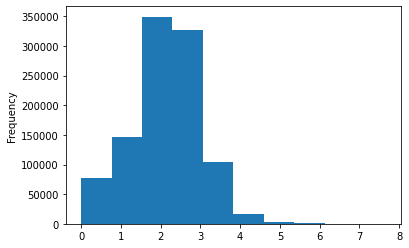

In [27]:
mobike_gdf_new['speed'][mobike_gdf_new['speed'] < average_speed + 0.5 * std].plot(kind = 'hist')

🤔 step 9 using this speed, calculate the distance corresponding to a 10min bike travel for the real estate company

In [28]:
distance_10min=average_speed*600
distance_10min

1297.49067799114

🤔 step 10 – *optionnal* – the speed can be adjusted and more precise if you use the path in the data instead of the starting and end coordinate. BUT be careful, the coordinates in the path are not ordered so you will have to reorder them. Once you have a clever algorithm, follow the steps again and provide a new estimation for the average speed 